In [1]:
from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

sns.set(style="darkgrid")

In [2]:
def loss(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> float:
    N = X.shape[0]
    z = np.dot(X,w) + w0

    log_loss = np.sum(np.log(1+np.exp(-y * z))) / N + gamma * np.sum(np.abs(w)) + beta * np.sum(np.abs(w))**2

    return log_loss

X = np.array([[1, 2], [3, 4], [1, 2]])
y = np.array([1, 0, 1])
w = [0.1, 0.2]
w0 = 0.3
gamma = 1.0
beta = 1.0

print(loss(X, y, w, w0, gamma, beta))

0.8684495041518336


In [3]:
def get_grad(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> Tuple[List[float], float]:

    N = X.shape[0]
    z = np.dot(X,w) +w0

    exp_log = np.exp(y*z)

    grad_w = -np.dot(X.T, y/(1+exp_log)) / N + gamma*np.sign(w) + 2*beta*w
    grad_w0 = -np.sum(y/(1+exp_log))/N

    return grad_w,grad_w0
np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
y = np.random.binomial(1, 0.42, size=10)
w, w0 = np.random.normal(size=5), np.random.normal()

grad_w, grad_w0 = get_grad(X, y, w, w0)
assert(np.allclose(grad_w,
                   [-2.73262076, -1.87176281, 1.30051144, 2.53598941, -2.71198109],
                   rtol=1e-2) & \
       np.allclose(grad_w0,
                   -0.2078231418067844,
                   rtol=1e-2)
)
print("Градиент весов:", grad_w)
print("Градиент смещения:", grad_w0)

Градиент весов: [-2.73262181 -1.87176392  1.30051023  2.53598816 -2.71198278]
Градиент смещения: -0.20782319347690742


In [4]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, roc_curve, auc

from sklearn.utils import check_random_state
class Logit(BaseEstimator, ClassifierMixin):
  def __init__(self, beta=1.0, gamma=1.0, lr=1e-2, tolerance=1e-8, max_iter=1000, random_state=42):
    self.beta = beta
    self.gamma = gamma
    self.lr = lr
    self.tolerance = tolerance
    self.max_iter = max_iter
    self.random_state = random_state
    self.w = None
    self.w0 = None
    self.loss_history = []
  def fit(self, X,y):
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features)
        self.w0 = 0.0
        rng = check_random_state(self.random_state)

        for _ in range(self.max_iter):
            idx = rng.randint(n_samples)
            X_i = X[idx:idx+1]
            y_i = y[idx:idx+1]

            dw, dw0 = self.get_grad(X_i, y_i, self.w, self.w0, self.gamma, self.beta)

            self.w -= self.lr * dw
            self.w0 -= self.lr * dw0

            self.loss_history.append(self.loss(X, y, self.gamma, self.beta))

            if np.linalg.norm(dw) < self.tolerance and np.abs(dw0) < self.tolerance:
                break
        self.best_th = self.find_best_th(X, y, metric='f1')

        return self
  def predict(self, X):
        z = np.dot(X, self.w) + self.w0
        p = 1 / (1 + np.exp(-z))
        return np.where(p >= self.best_th, 1, 0)

  def predict_proba(self, X):
        z = np.dot(X, self.w) + self.w0
        p = 1 / (1 + np.exp(-z))
        return np.column_stack((1 - p, p))

  def loss(self,X, y, gamma=1., beta=1.) -> float:
    N = X.shape[0]
    z = np.dot(X,self.w) + self.w0

    log_loss = np.sum(np.log(1+np.exp(-y * z))) / N + gamma * np.sum(np.abs(w)) + beta * np.sum(np.abs(w))**2

    return log_loss

  def get_grad(self, X, y, w: List[float], w0: float, gamma=1., beta=1.):

    N = X.shape[0]
    z = np.dot(X,w) + w0

    exp_log = np.exp(y*z)

    grad_w = -np.dot(X.T, y/(1+exp_log)) / N + gamma*np.sign(w) + 2*beta*w
    grad_w0 = -np.sum(y/(1+exp_log))/N

    return grad_w,grad_w0

  def find_best_th(self, X, y, metric='f1'):
        y_prob = self.predict_proba(X)[:, 1]
        best_threshold = 0.50
        best_score = 0

        for threshold in map(lambda a: float(a) / 100.0, range(101)):
            y_pred = np.where(y_prob >= threshold, 1, 0)
            if metric == 'f1':
                score = f1_score(y, y_pred)
            elif metric == 'accuracy':
                score = accuracy_score(y, y_pred)
            if score >= best_score:
                best_score = score
                best_threshold = threshold
        print('вероятность',best_threshold)
        return best_threshold
  def roc_auc(self, X: np.ndarray, y: np.ndarray) -> Tuple[np.ndarray, np.ndarray, float]:
        y_prob = self.predict_proba(X)[:, 1]
        fpr, tpr, _ = roc_curve(y, y_prob)
        roc_auc = auc(fpr, tpr)
        return roc_auc
def plot_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    print(x_min,x_max)
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o')
    plt.show()
def plot_loss_history(model):
    plt.plot(model.loss_history)
    plt.legend()
    plt.show()

[[ 1.11799341  0.71293496]
 [ 1.27601068  0.69206322]
 [ 1.15349472 -1.13830243]
 ...
 [ 1.29180265 -1.12041231]
 [ 1.56603544 -1.72257722]
 [ 0.20646107 -0.71638248]] [1 1 0 ... 0 0 0]
вероятность 0.98
-2.68627129451559 4.602936682059169


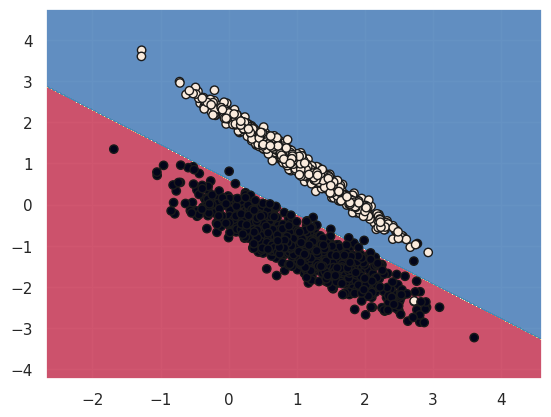

Веса [0.05892576 0.06977231]
Смещение 3.849150059084039
Прогнозы [1 1 0 ... 0 0 0]
Вероятности [[0.01861912 0.98138088]
 [0.01847613 0.98152387]
 [0.0210888  0.9789112 ]
 ...
 [0.02089566 0.97910434]
 [0.02143123 0.97856877]
 [0.02164004 0.97835996]]
Функция потерь 11.901417083722789
ROC AUC 0.9959172789102209
f1 0.9922480620155039
accuracy 0.9922222222222222


In [5]:
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1800, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)
print(X,y)
model = Logit(1,1,1e-1)
# y[y == 0] = -1
model.fit(X, y)
plot_decision_boundary(model, X, y)

print("Веса", model.w)
print("Смещение", model.w0)
print("Прогнозы", model.predict(X))
print("Вероятности", model.predict_proba(X))
print("Функция потерь", model.loss(X, y))
roc_auc = model.roc_auc(X, y)
print("ROC AUC", roc_auc)
print('f1', f1_score(model.predict(X), y))
print('accuracy', accuracy_score(model.predict(X), y))

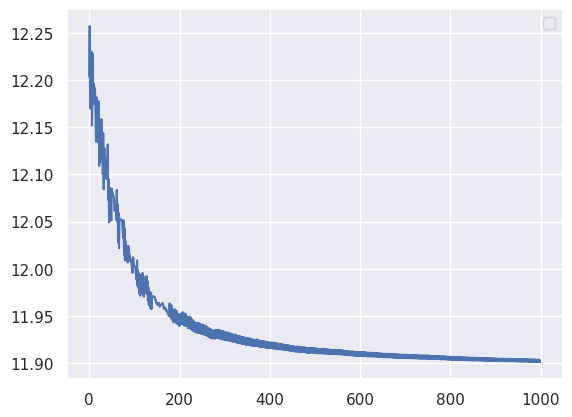

In [6]:
plot_loss_history(model)

In [7]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, roc_curve, auc

kernels = ['linear', 'poly', 'rbf', 'sigmoid']
C_values = [0.1, 1, 10]

def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X)

    acc = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    roc_auc = roc_auc_score(y, y_prob)

    fpr, tpr, _ = roc_curve(y, y_prob)
    roc_auc_value = auc(fpr, tpr)

    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"AUC-ROC: {roc_auc:.4f}")

    return fpr, tpr, roc_auc_value

for kernel in kernels:
    for C in C_values:
        print(f"Kernel: {kernel}, C: {C}")
        model = SVC(kernel=kernel, C=C, probability=True)
        model.fit(X, y)
        fpr, tpr, roc_auc_value = evaluate_model(model, X, y)


Kernel: linear, C: 0.1
Accuracy: 0.9956
Precision: 0.9945
Recall: 0.9967
F1-Score: 0.9956
AUC-ROC: 0.9963
Kernel: linear, C: 1
Accuracy: 0.9956
Precision: 0.9945
Recall: 0.9967
F1-Score: 0.9956
AUC-ROC: 0.9965
Kernel: linear, C: 10
Accuracy: 0.9956
Precision: 0.9945
Recall: 0.9967
F1-Score: 0.9956
AUC-ROC: 0.9965
Kernel: poly, C: 0.1
Accuracy: 0.9961
Precision: 0.9956
Recall: 0.9967
F1-Score: 0.9961
AUC-ROC: 0.9958
Kernel: poly, C: 1
Accuracy: 0.9961
Precision: 0.9956
Recall: 0.9967
F1-Score: 0.9961
AUC-ROC: 0.9967
Kernel: poly, C: 10
Accuracy: 0.9961
Precision: 0.9956
Recall: 0.9967
F1-Score: 0.9961
AUC-ROC: 0.9969
Kernel: rbf, C: 0.1
Accuracy: 0.9961
Precision: 0.9956
Recall: 0.9967
F1-Score: 0.9961
AUC-ROC: 0.9974
Kernel: rbf, C: 1
Accuracy: 0.9961
Precision: 0.9956
Recall: 0.9967
F1-Score: 0.9961
AUC-ROC: 0.9980
Kernel: rbf, C: 10
Accuracy: 0.9961
Precision: 0.9956
Recall: 0.9967
F1-Score: 0.9961
AUC-ROC: 0.9984
Kernel: sigmoid, C: 0.1
Accuracy: 0.9628
Precision: 0.9826
Recall: 0.9

In [8]:
from sklearn.model_selection import train_test_split
class KNNClassifier(BaseEstimator, ClassifierMixin):
  def __init__(self, n_neighbors=5):
    self.n_neighbors = n_neighbors
    self.X_train = None
    self.y_train = None
  def fit(self,X,y):
    self.X_train = X
    self.y_train = y
  def predict(self,X):
    proba = self.predict_proba(X)
    return np.where(proba[:, 1] >= 0.5, 1, 0)
  def predict_proba(self,X):
    distances = [self._dist(x) for x in X]

    proba = np.zeros((X.shape[0], 2))
    for i, dist in enumerate(distances):
        k_indices = np.argsort(dist)[:self.n_neighbors]
        k_nearest_labels = [self.y_train[ix] for ix in k_indices]
        proba[i, 0] = np.mean(np.array(k_nearest_labels) == 0)
        proba[i, 1] = np.mean(np.array(k_nearest_labels) == 1)

    return proba

  def _dist(self,x):
    distances = [np.sqrt(np.sum((x - x_train) ** 2)) for x_train in self.X_train]
    return distances

X, y = make_classification(n_samples=300, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

knn = KNNClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
y_proba = knn.predict_proba(X_test)

frp,trp,auc_roc = evaluate_model(knn,X_test,y_test)

Accuracy: 0.9556
Precision: 0.9762
Recall: 0.9318
F1-Score: 0.9535
AUC-ROC: 0.9617


,Id,Category,Pixel000,Pixel001,Pixel002,Pixel003,Pixel004,Pixel005,Pixel006,Pixel007,Pixel008,Pixel009,Pixel010,Pixel011,Pixel012,Pixel013,Pixel014,Pixel015,Pixel016,Pixel017,Pixel018,Pixel019,Pixel020,Pixel021,Pixel022,Pixel023,Pixel024,Pixel025,Pixel026,Pixel027,Pixel028,Pixel029,Pixel030,Pixel031,Pixel032,Pixel033,Pixel034,Pixel035,Pixel036,Pixel037,Pixel038,Pixel039,Pixel040,Pixel041,Pixel042,Pixel043,Pixel044,Pixel045,Pixel046,Pixel047,Pixel048,Pixel049,Pixel050,Pixel051,Pixel052,Pixel053,Pixel054,Pixel055,Pixel056,Pixel057,Pixel058,Pixel059,Pixel060,Pixel061,Pixel062,Pixel063,Pixel064,Pixel065,Pixel066,Pixel067,Pixel068,Pixel069,Pixel070,Pixel071,Pixel072,Pixel073,Pixel074,Pixel075,Pixel076,Pixel077,Pixel078,Pixel079,Pixel080,Pixel081,Pixel082,Pixel083,Pixel084,Pixel085,Pixel086,Pixel087,Pixel088,Pixel089,Pixel090,Pixel091,Pixel092,Pixel093,Pixel094,Pixel095,Pixel096,Pixel097,Pixel098,Pixel099,Pixel100,Pixel101,Pixel102,Pixel103,Pixel104,Pixel105,Pixel106,Pixel107,Pixel108,Pixel109,Pixel110,Pixel111,Pixel112,Pixel113,Pixel114,Pixel115,Pixel116,Pixel117,Pixel118,Pixel119,Pixel120,Pixel121,Pixel122,Pixel123,Pixel124,Pixel125,Pixel126,Pixel127,Pixel128,Pixel129,Pixel130,Pixel131,Pixel132,Pixel133,Pixel134,Pixel135,Pixel136,Pixel137,Pixel138,Pixel139,Pixel140,Pixel141,Pixel142,Pixel143,Pixel144,Pixel145,Pixel146,Pixel147,Pixel148,Pixel149,Pixel150,Pixel151,Pixel152,Pixel153,Pixel154,Pixel155,Pixel156,Pixel157,Pixel158,Pixel159,Pixel160,Pixel161,Pixel162,Pixel163,Pixel164,Pixel165,Pixel166,Pixel167,Pixel168,Pixel169,Pixel170,Pixel171,Pixel172,Pixel173,Pixel174,Pixel175,Pixel176,Pixel177,Pixel178,Pixel179,Pixel180,Pixel181,Pixel182,Pixel183,Pixel184,Pixel185,Pixel186,Pixel187,Pixel188,Pixel189,Pixel190,Pixel191,Pixel192,Pixel193,Pixel194,Pixel195,Pixel196,Pixel197,Pixel198,Pixel199,Pixel200,Pixel201,Pixel202,Pixel203,Pixel204,Pixel205,Pixel206,Pixel207,Pixel208,Pixel209,Pixel210,Pixel211,Pixel212,Pixel213,Pixel214,Pixel215,Pixel216,Pixel217,Pixel218,Pixel219,Pixel220,Pixel221,Pixel222,Pixel223,Pixel224,Pixel225,Pixel226,Pixel227,Pixel228,Pixel229,Pixel230,Pixel231,Pixel232,Pixel233,Pixel234,Pixel235,Pixel236,Pixel237,Pixel238,Pixel239,Pixel240,Pixel241,Pixel242,Pixel243,Pixel244,Pixel245,Pixel246,Pixel247,Pixel248,Pixel249,Pixel250,Pixel251,Pixel252,Pixel253,Pixel254,Pixel255,Pixel256,Pixel257,Pixel258,Pixel259,Pixel260,Pixel261,Pixel262,Pixel263,Pixel264,Pixel265,Pixel266,Pixel267,Pixel268,Pixel269,Pixel270,Pixel271,Pixel272,Pixel273,Pixel274,Pixel275,Pixel276,Pixel277,Pixel278,Pixel279,Pixel280,Pixel281,Pixel282,Pixel283,Pixel284,Pixel285,Pixel286,Pixel287,Pixel288,Pixel289,Pixel290,Pixel291,Pixel292,Pixel293,Pixel294,Pixel295,Pixel296,Pixel297,Pixel298,Pixel299,Pixel300,Pixel301,Pixel302,Pixel303,Pixel304,Pixel305,Pixel306,Pixel307,Pixel308,Pixel309,Pixel310,Pixel311,Pixel312,Pixel313,Pixel314,Pixel315,Pixel316,Pixel317,Pixel318,Pixel319,Pixel320,Pixel321,Pixel322,Pixel323,Pixel324,Pixel325,Pixel326,Pixel327,Pixel328,Pixel329,Pixel330,Pixel331,Pixel332,Pixel333,Pixel334,Pixel335,Pixel336,Pixel337,Pixel338,Pixel339,Pixel340,Pixel341,Pixel342,Pixel343,Pixel344,Pixel345,Pixel346,Pixel347,Pixel348,Pixel349,Pixel350,Pixel351,Pixel352,Pixel353,Pixel354,Pixel355,Pixel356,Pixel357,Pixel358,Pixel359,Pixel360,Pixel361,Pixel362,Pixel363,Pixel364,Pixel365,Pixel366,Pixel367,Pixel368,Pixel369,Pixel370,Pixel371,Pixel372,Pixel373,Pixel374,Pixel375,Pixel376,Pixel377,Pixel378,Pixel379,Pixel380,Pixel381,Pixel382,Pixel383,Pixel384,Pixel385,Pixel386,Pixel387,Pixel388,Pixel389,Pixel390,Pixel391,Pixel392,Pixel393,Pixel394,Pixel395,Pixel396,Pixel397,Pixel398,Pixel399,Pixel400,Pixel401,Pixel402,Pixel403,Pixel404,Pixel405,Pixel406,Pixel407,Pixel408,Pixel409,Pixel410,Pixel411,Pixel412,Pixel413,Pixel414,Pixel415,Pixel416,Pixel417,Pixel418,Pixel419,Pixel420,Pixel421,Pixel422,Pixel423,Pixel424,Pixel425,Pixel426,Pixel427,Pixel428,Pixel429,Pixel430,Pixel431,Pixel432,Pixel433,Pixel434,Pixel435,Pixel436,Pixel437,Pixel438,Pixel439,Pixel440,Pixel441,Pixel442,

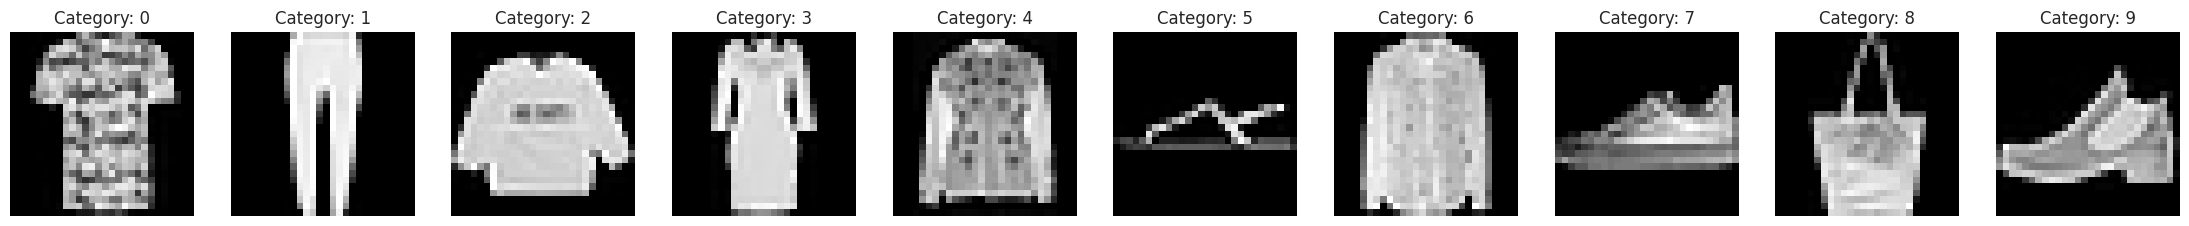

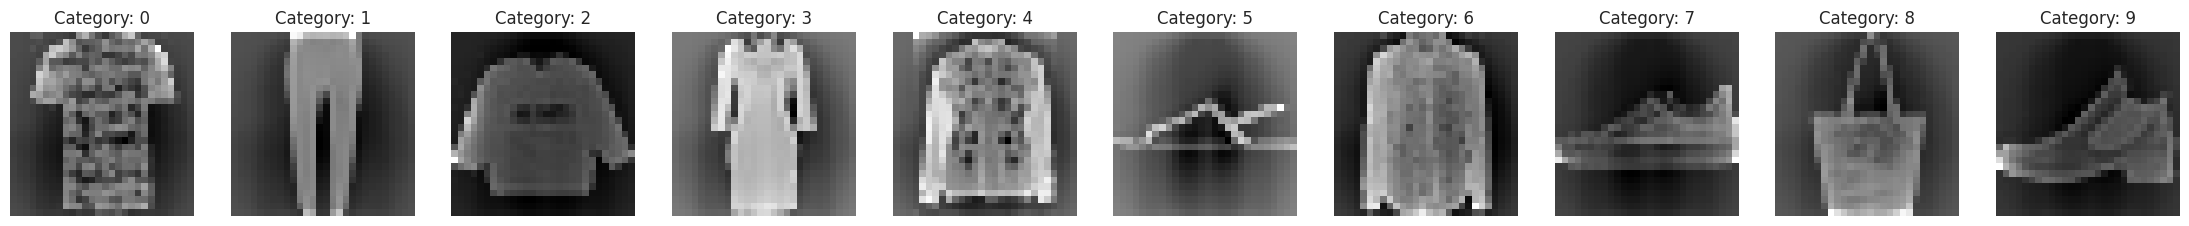

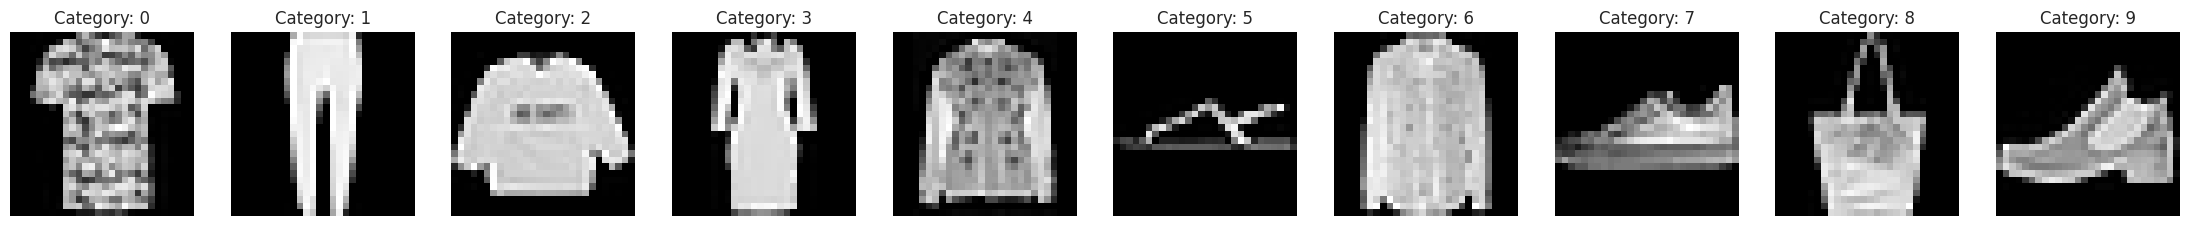

In [9]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

df = pd.read_csv('train.csv', sep = ',')
df = pd.DataFrame(df)
display(df.head(10))


X = df.drop(columns=['Id', 'Category']).values
y = df['Category'].values
categ = set(df['Category'].values)
X = X.reshape(-1, 28, 28)

def visualize_first_n_objects(X, y,categ):
    fig, axes = plt.subplots(1, 10, figsize=(28, 28))
    i = 0
    for i in range(len(categ)):
          ix = np.where(y==i)[0][0]
          axes[i].imshow(X[ix], cmap='gray')
          axes[i].set_title(f'Category: {i}')
          axes[i].axis('off')
    plt.show()

visualize_first_n_objects(X, y,categ)
scaler = StandardScaler()
X_standard = scaler.fit_transform(X.reshape(-1, 28*28)).reshape(-1, 28, 28)
# print(X_standard)
scaler = MinMaxScaler()
X_minmax = scaler.fit_transform(X.reshape(-1, 28*28)).reshape(-1, 28, 28)

visualize_first_n_objects(X_standard, y, categ)
# print(X_minmax)
visualize_first_n_objects(X_minmax, y, categ)


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

X = df.drop(columns=['Id', 'Category']).values
y = df['Category'].values

X_train = X[:50000]
y_train = y[:50000]
X_test = X[50000:]
y_test = y[50000:]

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

knn = KNeighborsClassifier()
param_grid = {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']}
knn_cv = GridSearchCV(knn,param_grid,cv = 5,scoring = 'accuracy',error_score='raise')
knn_cv.fit(X_train, y_train)

print("Best parameters:", knn_cv.best_params_)
print("Best accuracy", knn_cv.best_score_)

knn_best = knn_cv.best_estimator_
y_pred_knn = knn_best.predict(X_test)
print("accuracy", accuracy_score(y_test, y_pred_knn))

In [ ]:
lr_param_grid = {'C': [0.1, 1, 10], 'solver': ['lbfgs', 'liblinear', 'saga'],'penalty': ['l1', 'l2']}
lr = LogisticRegression()
lr_cv = GridSearchCV(lr, lr_param_grid, cv=5, scoring='accuracy')

lr_cv.fit(X_train, y_train)
print("Best parameters for LogisticRegression:", lr_cv.best_params_)
print("Best accuracy for LogisticRegression:", lr_cv.best_score_)

lr_best = lr_cv.best_estimator_
y_pred_lr = lr_best.predict(X_test)
print("Test accuracy for LogisticRegression:", accuracy_score(y_test, y_pred_lr))

Бонус 1:
в итоге обучения sgd не будет менять веса или будет делать это очень медленно тк все параметры одинаковые.в результате обучения модель не найдёт никаких зависимостей и будет правильный ответ выдавать с шансов в 50%


In [16]:
lr = LogisticRegression(max_iter = 1000,solver = 'lbfgs')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print(accuracy_score(y_pred,y_test))

0.8406


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Бонус 2

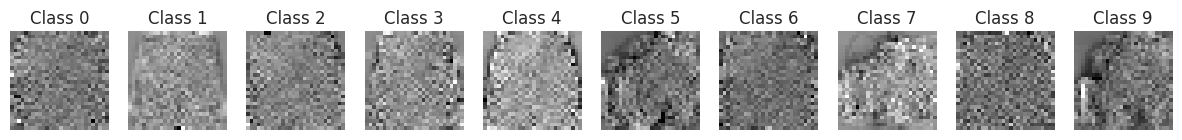

In [17]:
weights = lr.coef_

fig, axes = plt.subplots(1, 10, figsize=(15, 15))
for i in range(10):
    axes[i].imshow(weights[i].reshape(28, 28), cmap='gray')
    axes[i].set_title(f'Class {i}')
    axes[i].axis('off')
plt.show()

для каждого класса прослеживаются силуэты одежды соответсвующей категории